Stages of this analysis, in order to draw appropriate conclusions
Do this across multiple sessions
1. With regular PCA, we can see how multiple regions contribute (can correlate functional connectivity)
2. By separating out in time (50-60 bins and 60-70 in bins) we can see which modes are most active in each

        2a. Predict that ~sensory regions contribute early and ~memory/dm regions contribute later
3. With sparse PCA, we can see how individual regions contribute, also in each time bin
4. Cluster activity in regular and sparse to see whether slow/fast and small margin/large margin separate
5. Using decision tree, on regular and sparse in turn, try to predict slow/fast response, small/large margin, left/right (as control), and correct/incorrect
6. Take outcomes from 4 and 5 to refer back to the PC contributions from each area to draw conclusions

In [1]:
#@title Data loading and imports
import numpy as np
from sklearn.decomposition import PCA, SparsePCA
import matplotlib.pyplot as plt
from copy import deepcopy as cdc
from matplotlib import rcParams 
from matplotlib import pyplot as plt
import pandas as pd

from sklearn.utils import resample
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.tree import plot_tree
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.metrics import completeness_score

#import helper functions
from utils import *

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True



In [2]:
alldat = np.array([])
for j in range(3):
    alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx. 
dat = alldat[11]
print(dat.keys())


dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])


In [13]:
#@title Creating our boolean masks for each dependent variable: incorrect/correct, slow/fast, large vs small margin,
#non passive trials
dt = dat['bin_size'] # binning at 10 ms
NT = dat['spks'].shape[-1]

response = dat['response'] # right - nogo - left (-1, 0, 1)
vis_right = dat['contrast_right'] # 0 - low - high
vis_left = dat['contrast_left'] # 0 - low - high


is_correct = np.logical_and(np.sign(response)==np.sign(vis_left-vis_right),response != 0,
                            np.sign(vis_left - vis_right) != 0)
is_large_margin = np.logical_and(np.abs(vis_left-vis_right) >= 0.5, response != 0)

slow_resp = (dat['response_time'] > np.mean(dat['response_time'])).squeeze()
slow_resp = np.logical_and(slow_resp, response!=0)


In [20]:
#@title Exploratory Data Analysis: Can we differentiate any features of neural activity in our classes?
# groupings of brain regions
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "other"]
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ]

nareas = 4 # only the top 4 regions are in this particular mouse
NN = len(dat['brain_area']) # number of neurons
barea = nareas * np.ones(NN, ) # last one is "other"
for j in range(nareas):
    barea[np.isin(dat['brain_area'], brain_groups[j])] = j # assign a number to each region
    


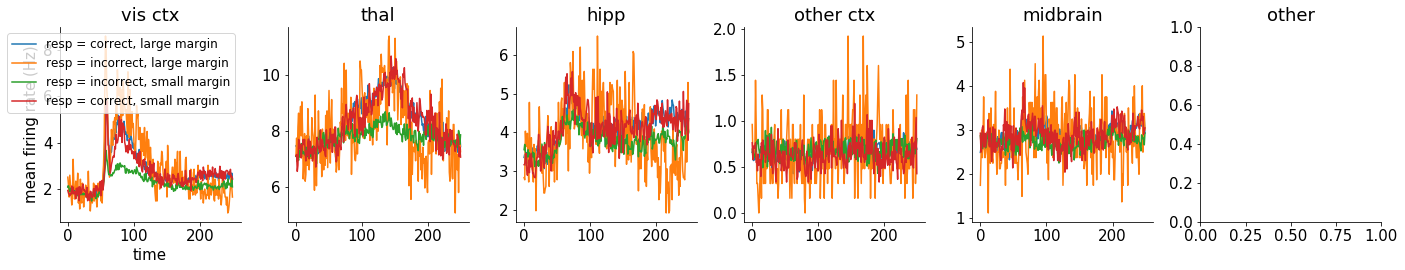

In [24]:
for j in range(len(brain_groups)+1):
    ax = plt.subplot(1,len(brain_groups)+1,j+1)
    plt.title(regions[j])
    if np.sum(barea==j)==0:
        continue
    plt.plot(1/dt * dat['spks'][barea==j][:,np.logical_and(is_correct, is_large_margin)].mean(axis=(0,1)))  
    plt.plot(1/dt * dat['spks'][barea==j][:, np.logical_and(~is_correct, is_large_margin)].mean(axis=(0,1)))
    plt.plot(1/dt * dat['spks'][barea==j][:, np.logical_and(~is_correct, ~is_large_margin)].mean(axis=(0,1)))
    plt.plot(1/dt * dat['spks'][barea==j][:, np.logical_and(is_correct, ~is_large_margin)].mean(axis=(0,1)))
    #plt.plot(1/dt * dat['spks'][barea==j][:,response==0].mean(axis=(0,1)))
 
    if j==0:
        plt.legend(['resp = correct, large margin', 'resp = incorrect, large margin', 'resp = incorrect, small margin', 'resp = correct, small margin'], fontsize=12)
        ax.set(xlabel = 'time', ylabel = 'mean firing rate (Hz)')
  #print(np.abs(vis_left-vis_right))



C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.canvas.print_figure(bytes_io, **kw)


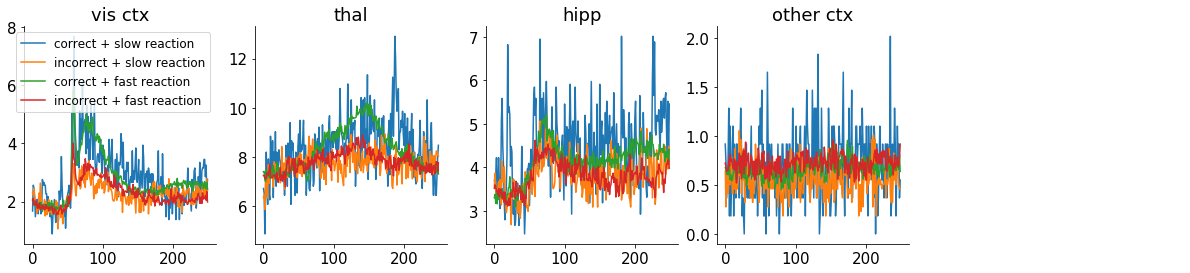

In [23]:
#@title plots by BRAIN REGION and right/wrong, speed
for j in range(4): #len(brain_groups)+1):
    x = plt.subplot(1,5, j+1) # len(brain_groups)+1,j+1)
    plt.title(regions[j])
    b_spikes = dat['spks'][barea==j];
    plt.plot(1/dt *  b_spikes[:,np.logical_and(is_correct, slow_resp)].mean(axis=(0,1)))
    plt.plot(1/dt *  b_spikes[:,np.logical_and(~is_correct, slow_resp)].mean(axis=(0,1)))
    plt.plot(1/dt *  b_spikes[:,np.logical_and(is_correct, ~slow_resp)].mean(axis=(0,1)))
    plt.plot(1/dt *  b_spikes[:,np.logical_and(~is_correct, ~slow_resp)].mean(axis=(0,1)))  
    plt.text(.25, .92, 'n=%d'%np.sum(barea==j), transform=ax.transAxes)

    if j==0:
        plt.legend(['correct + slow reaction', 'incorrect + slow reaction', 'correct + fast reaction', 'incorrect + fast reaction'], fontsize=12)
        ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')


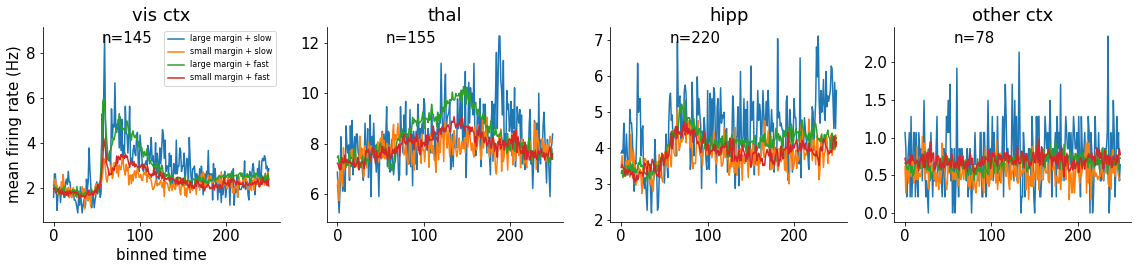

In [26]:
#@title plots by brain region and margin, speed
for j in range(4): #len(brain_groups)+1):
    ax = plt.subplot(1,5, j+1) # len(brain_groups)+1,j+1)
    plt.title(regions[j])
    b_spikes = dat['spks'][barea==j];
    plt.plot(1/dt *  b_spikes[:,np.logical_and(is_large_margin, slow_resp)].mean(axis=(0,1)))
    plt.plot(1/dt *  b_spikes[:,np.logical_and(~is_large_margin, slow_resp)].mean(axis=(0,1)))
    plt.plot(1/dt *  b_spikes[:,np.logical_and(is_large_margin, ~slow_resp)].mean(axis=(0,1)))
    plt.plot(1/dt *  b_spikes[:,np.logical_and(~is_large_margin, ~slow_resp)].mean(axis=(0,1)))  
    plt.text(.25, .92, 'n=%d'%np.sum(barea==j), transform=ax.transAxes)
 
    if j==0:
        plt.legend(['large margin + slow', 'small margin + slow', 'large margin + fast', 'small margin + fast'], fontsize=8)
        ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')
